# **< 지역날씨 빅데이터 분석 >**

---

## **▶ 주제: 강릉지역 10년간 바람 경향분석 ◀**


> ### 팀명 : 불어라 바람 風 !

> ### 팀원 : 이종환, 황희지, 정혜윤, 권용민




 본 과제에서는 최근 10년간 강릉 바람의 경향을 연도별, 계절별 등으로 분석하여 분석 결과를 시각화 자료로 제공하는 것을 최종적인 목표로 함.




### **1) 배경/동기**

**올해 3월에 태풍급 강풍을 직접 겪은 후 강릉의 바람에 대한 관심이 생겨 경향 분석을 하고싶었음.**


### **2) 자료출처**

**기상청 기상자료개방포털 종관기상관측(ASOS) 데이터셋 분자료**를 조회하여

강원도 강릉(105)지점 2010~2020년 기간의 풍향(deg) , 풍속(m/s), 기온(°C)자료를 사용

### **3) 가설**


1.   겨울에는 서고동저의 기압배치로 북서풍, 여름에는 남고북저 남풍이 불 것이다.
2.   겨울이 다른 계절보다 풍속이 강할 것이다.


### **4) 역할**
* 이종환: 푸리에 변환 (+ 그래프) , 전처리(결측값 처리), 이동평균
* 황희지: 코사인 유사도(+ 그래프), 전처리(리샘플링), 발표
* 정혜윤: 전처리(데이터 병합, 결측값 처리), 바람장미 시각화, 발표
* 권용민: 데이터 다운, 전처리(데이터 병합), 바람장미 시각화(정규화)


### **5) 한계점**

**① 처음에 뚜렷한 가설을 세우지 않고 분석을 목표로 했음**

**② 목표가 광범위해서 이것저것 하려다 보니 끝맺음이 확실하지 않았음**

**③ 푸리에 개념을 완벽히 이해하지 못함**

**④ 결과의 원인을 분석할 시간과 전문지식이 부족했음**



> ### INDEX 
1.   Data Collecting
2.   Data Merge
3.   Find Missing Data (NaN)
4.   Interpolate Data
5.   Fourier Transform (FT)
6.   Missing Data Resampling
7.   Moving Average (One Day)
8.   Plot WindRose
9.   Analyze Output
10.  Q & A 





---

In [ ]:
# 모듈 불러오기

#!pip install windrose
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import sys
import seaborn as sns
#sys.path.append('/content/drive/My Drive/데이터 통합/CODE')
#from Jiwoo import WDROSE as WS  #이름 바꾸기
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#구글 드라이브 코랩에 마운트 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### **1. Data Collecting(데이터 설명)**

###### **1-1. Data Download**

In [ ]:
# 용민이 코드 어필

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from urllib import parse
import time

options = Options()
options.add_argument('--start-fullscreen')
options.add_experimental_option("prefs", {
	"profile.default_content_setting_values.automatic_downloads" : 1
	})
driver = webdriver.Chrome(executable_path="c:/chromedriver_win32/chromedriver.exe", chrome_options=options)
url = "https://data.kma.go.kr/cmmn/main.do"


try:
	driver.get(url)
	#로그인
	login_path = '//*[@id="loginBtn"]'
	login_btn  = driver.find_element_by_xpath(login_path)
	driver.execute_script("arguments[0].click();", login_btn)

	id_path = '//*[@id="loginId"]'
	id_in   = driver.find_element_by_xpath(id_path)
	id_in.send_keys("MY_ID")
	pw_path = '//*[@id="passwordNo"]'
	pw_in   = driver.find_element_by_xpath(pw_path)
	pw_in.send_keys("MY_PW")
	time.sleep(1)

	btn_path= '//*[@id="loginbtn"]'
	btn_ = driver.find_element_by_xpath(btn_path)
	driver.execute_script("arguments[0].click();", btn_)

	time.sleep(2)

	#자료 검색
	css_ = "#mwrap > div.mgnb-wrap > div > ul > li:nth-child(2) > a"
	obs = driver.find_element_by_css_selector(css_)
	obs.click()
    

	d_css_ = "#content > div.content-body > div:nth-child(13) > div > ul > li:nth-child(2) > a"
	dataset_menu = driver.find_element_by_css_selector(d_css_)
	driver.execute_script("arguments[0].click();", dataset_menu)
	time.sleep(2)

	def select_freq(data_freq):
		freq = driver.find_element_by_xpath('//*[@id="dataFormCd"]/option[' + str(data_freq) + ']')
		freq.click()

		time.sleep(2)

	select_freq(6)
	#2 : 시간자료 3 : 일 자료 4 : 월 자료 5 : 년 자료 6: 분 자료  

	def select_date(start_year, end_year):
		start_path = '//*[@id="startDt"]/option['
		end_path   = '//*[@id="endDt"]/option['

		start = driver.find_element_by_xpath(start_path + str(start_year) + ']')
		start.click()
		end   = driver.find_element_by_xpath(end_path + str(end_year) + ']')
		end.click()

		time.sleep(1)

	def select_asos(asos_loc):
		expand_path = '//*[@id="ztree_26_switch"]'
		expand = driver.find_element_by_xpath(expand_path)
		expand.click()

		#loc_path = '//*[@id="ztree_' + str(asos_loc) + '_check"]'
		loc_path = '//*[@id="ztree_27_check"]'
		loc = driver.find_element_by_xpath(loc_path)
		driver.execute_script("arguments[0].click();", loc)
		#if loc.get_attribute('checked'):
		#loc.click()

		time.sleep(1)


	select_date(13, 2)
	#13 : 2009, 2 : 2020
	select_asos(27)
	#27 : 강릉
	search_btn_path = '//*[@id="dsForm"]/div[2]/a'
	search_btn = driver.find_element_by_xpath(search_btn_path)
	driver.execute_script("arguments[0].click();", search_btn)

	time.sleep(2)

	for i in range(2,15):
		select_all_path = '//*[@id="checkAll"]'
		select_all_btn = driver.find_element_by_xpath(select_all_path)
		driver.execute_script("arguments[0].click();", select_all_btn)

		driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
		down_path = '//*[@id="content"]/div[3]/div[6]/div/div[2]/a'
		down_btn  = driver.find_element_by_xpath(down_path)
		driver.execute_script("arguments[0].click();", down_btn)
		time.sleep(2)

		reqst_path = '//*[@id="reqstPurposeCd10"]'
		reqst_btn  = driver.find_element_by_xpath(reqst_path)
		driver.execute_script("arguments[0].click();", reqst_btn)

		get_path = '//*[@id="btnArea"]/input[2]'
		get_btn  = driver.find_element_by_xpath(get_path)
		driver.execute_script('fnRequest();', get_btn)

		#time.sleep(10)
		driver.execute_script("goPage(%s);" % i)

	time.sleep(5)



except Exception as e:
    print(e)
finally:
    driver.quit()

###### **1-2. Unzip Data**

In [ ]:
import zipfile
import os

def UNZIP(FILEN, ex_dire):
    for i in range(len(FILEN)):
        fantasy_zip = zipfile.ZipFile(FILEN[i])
        fantasy_zip.extractall(ex_dire)
    fantasy_zip.close()

FILEN = os.listdir("C:/Users/ATOMS8/Data/")[1:-2]
ex_dire = "C:/Users/ATOMS8/Data/"
UNZIP(FILEN, ex_dire)

#### **2. Data Merge**

In [ ]:
def MERGE(DIRE, FILEN, inp_, save_dir = None, file_name = None):
    
    if inp_ == "xls":
        df_base = pd.read_csv(DIRE + FILEN[0], encoding = "CP949", error_bad_lines=False, sep = '\t')
        
        for i in range(1, len(FILEN)):
            df = pd.read_csv(DIRE + FILEN[i], encoding = "CP949", error_bad_lines=False, sep = '\t')
            df_base = pd.concat([df_base, df])
            print("steps == {}".format(i))
        
            if i == (len(FILEN) - 1):
                print("====================================================")
                print("Total len : {}".format(len(df_base)))
                print("====================PROCESS DONE====================")
        
                if save_dir == None:
                    break

                else:
                    filn = save_dir + file_name
                    df_base.to_csv(filn + ".csv", index = False, encoding = 'CP949')
                    print("File Name : {}".format(filn + ".csv"))
                    print("======================SAVE DONE======================")
                    
                
    else:
        df_base = pd.read_csv(DIRE + FILEN[0], encoding = "CP949")
    
        for i in range(1, len(FILEN)):
            df = pd.read_csv(DIRE + FILEN[i], encoding = "CP949")
            df_base = pd.concat([df_base, df])
            print("steps == {}".format(i))

            if i == (len(FILEN) - 1):
                print("====================================================")
                print("Total len : {}".format(len(df_base)))
                print("====================PROCESS DONE====================")

                if save_dir == None:
                    break

                else:
                    filn = save_dir + file_name
                    df_base.to_csv(filn + ".csv", index = False, encoding = 'CP949')
                    print("File Name : {}".format(filn + ".csv"))
                    print("======================SAVE DONE======================")
                    
                
    return df_base
  



```
DIRE = "C:/Users/ATOMS8/Data/MERGE/"
FILEN = os.listdir("C:/Users/ATOMS8/Data/MERGE")
SAVED = "C:/Users/ATOMS8/Data/"
SAVEN = "data_merge"
Merged_data = MERGE(DIRE, FILEN, "csv", SAVED, SAVEN)


```



### **3. Find Missing Data (NaN)**

In [ ]:
# 저장한 데이터 불러오기 및 결측값 확인

data_merge = pd.read_csv(r'/content/drive/My Drive/데이터 통합/DATA/MERGED/data_merge.csv',encoding='CP949')

data_merge.isnull().sum()

지점                0
시간                0
기온(°C)         1700
누적강수량(mm)     87361
풍향(deg)        7589
풍속(m/s)        7514
현지기압(hPa)      8011
해면기압(hPa)      7702
습도(%)           841
일사(MJ/m^2)      808
일조(Sec)         588
dtype: int64

### **4. Interpolate Data**

In [ ]:
from IPython.display import Image
import PIL.Image as pilimg

> #### **보간(Interpolation)법이란?**

　**알려진 두 지점의 값 사이(중간)에 위치한 값을 알려진 값으로부터 추정하는 방법**
　
> #### **보간법의 종류**

1.   최근린 보간법(Nearest neighbor interpolate)
2.   선형 보간법(Linear interpolation)
3.   다항식 보간법(Polynomial interpolation)
4.   스플라인 보간법(Spline interpolation)




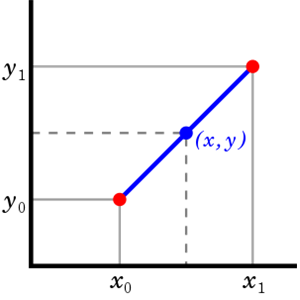

In [ ]:
a = pilimg.open('/content/drive/My Drive/데이터 통합/interpolate.png')
a

> #### **선형보간법이란?**
　**주어진 2개의 점을 직선으로 연결하여 가운데 값을 추정하는 방법**
　


>#### **선형보간법 선정 이유**

1.   **데이터의 NaN값을 처리하기 위해 선형보간법을 사용**
2.   **시계열의 결측 기간이 길어져도 스펙트럼에 덜 민감하게 반응하는 보간법 중 비교적 간단한 선형보간법을 선택**
3.   **이렇게 보정된 시계열을 사용하여 푸리에 변환과 이동평균을 수행하였음.**
　


<내용 출처: 강원 중부 산지 및 동해안 지상 바람 시계열 스펙트럼 분석 논문 (저자: 김제원, 강성락)>

In [ ]:
# 결측값 내삽 (linear interpolate ; 선형보간법)
 
data_nan = data_merge.interpolate(method='linear',limit_direction='forward',inplace=True)

#### **5. Fourier Transform (FT)**

> #### **이동평균을 해야 하는 이유는 무엇일까?**
**1분단위 간격의 관측이 여러 다중 규모가 포함된 시계열 자료이기 때문에 이동평균등의 "필터링 방법"을 사용하여 분석에 불필요한 규모나 난류등의 영향을 "최소화" 하기 위함.**

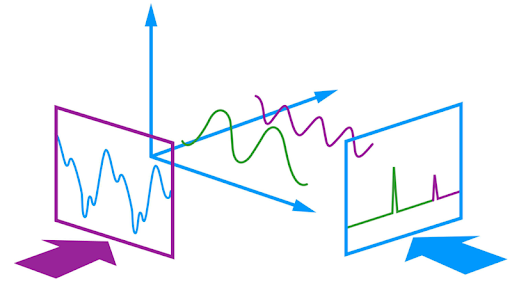

In [ ]:
b = pilimg.open('/content/drive/My Drive/데이터 통합/푸리에.png')
b

> #### **푸리에 변환(Fourier Transform)?**
1.   **임의의 시간에 대한 함수를 다양한 진동수를 갖는 주기함수들의 합으로 분해하여 표현하는 것이다.**
2.   **이 과정을 통해 어느 진동수가 시간에 대한 함수에 강하게 영향을 주었는지 파악 할 수가 있다.**





> #### **푸리에 변환을 한 이유?**
1.   **우리는 난류에 대한 영향을 최소화 하기 위해 이동평균을 해야 함.**
2.   **이동평균을 할 때 어느 시간간격으로 평균을 할지 알아내고, 근거를 제시하기 위해서 했다.**

In [ ]:
DIRE = "/content/drive/My Drive/데이터 통합/DATA/MERGED/data_nan.csv"
Data = pd.read_csv(DIRE, encoding = "CP949")

#sig = np.array(Data["기온(°C)"])
sig = np.array(Data["풍속(m/s)"])

In [ ]:
fourier = abs(np.fft.fft(sig) / len(sig))
n = sig.size
freq = np.fft.fftfreq(n, 60)

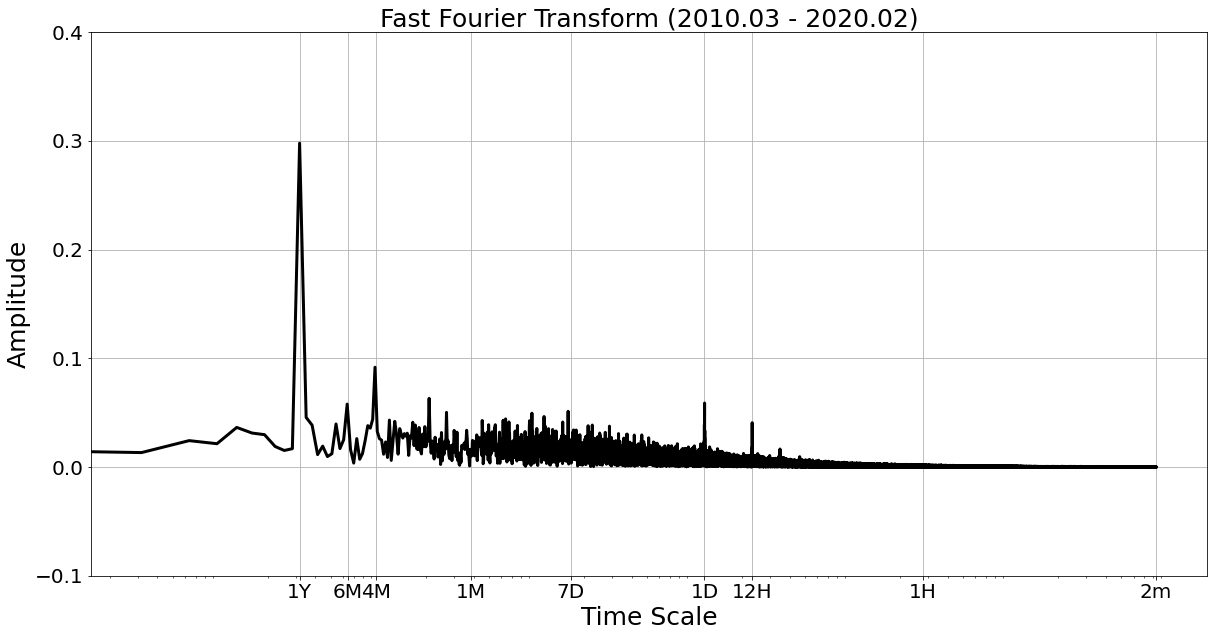

In [ ]:
plt.subplots(figsize = [20,10])
plt.semilogx(freq[:int(n/2)], fourier[:int(n/2)], color = 'black', linewidth = 3)
#plt.xscale('log')
#plt.yscale('log')

plt.ylim(- 0.1, 0.4)
L = [1/ 120, 1 / (60 * 60), 1 / (60 * 60 * 12), 1 / (60 * 60 * 24), 1 / (60 * 60 * 24 * 7),1 / (60 * 60 * 24* 30) , 1 / (60 * 60 * 24* 30 * 4), 1 / (60 * 60 * 24* 30 * 6), 1 / (60 * 60 * 24 * 365)]
plt.xticks(np.array(L), ["2m","1H", "12H", "1D", "7D", "1M", "4M", "6M", "1Y"], fontsize = 20);
plt.yticks(fontsize = 20);

plt.grid(True)

plt.xlabel("Time Scale", fontsize = 25)
plt.ylabel("Amplitude", fontsize = 25)

plt.title("Fast Fourier Transform (2010.03 - 2020.02)", fontsize = 25);

plt.savefig("/content/drive/My Drive/데이터 통합/FFT.png", bbox_inches = "tight")

진동수 그래프를 보면 1년, 4개월, 하루 정도 피크가 있는데, 우리는 이 중 **하루**에 집중하고자 하였다.

그 이유는 1년이나 4개월로 이동평균을 한다면, 그 데이터는 종관 규모보다 큰 규모로 필터링 되기때문에 기상학적으로 의미가 강한 종관규모, 중규모에 대한 영향이 최소화 되어져 분석이 어려울 것이라 생각하였다.

 따라서 종관규모와 중규모에 대한 영향은 남기고, 그보다 작은 규모의 영향을 최소화 하기 위해 하루 이동평균을 적용하기로 결정하였다.

#### **6. Missing Data Resampling**

> #### **Resampling ?**
**리샘플링은 시계열의 빈도를 변환하는 과정을 말한다.**

> #### **Resampling 을 하는 이유?**
**분자료의 row가 아예 없는 missing data들이 발견되어서 이것의 Datetime을 채우기 위하여 1분 간격으로의 resample을 진행하였으며 채워진 dateime에서의 풍향, 풍속, 온도 결측값을 linear interploate 방법으로 채움**

In [ ]:
data = pd.read_csv("/content/drive/My Drive/데이터 통합/DATA/data_real.csv", encoding = "CP949") # 데이터 불러오기

data["시간"] = pd.DatetimeIndex(data["시간"])  # 시계열 자료를 생성하기위해 인덱스를 DatetimeIndex 자료형으로 만듦

data.drop(["지점"], axis = 1, inplace = True)  # '지점' column을 삭제

data.index = data["시간"].values    # data["시간"] 을 인덱스 없이 Series로 확인하기 위함

data.drop(["시간"], axis = 1, inplace = True)  # '시간' column을 삭제

data_re = data.resample('T').interpolate('linear')  # 누락된 Datetime 분 자료들을 interpolate을 이용해 채워넣음

data_re.to_csv("/content/drive/My Drive/데이터 통합/DATA/MERGED/resampled.csv", encoding = "CP949", index = False)  # 데이터 저장

#### **7. Moving Average (One Day)**



```
# 이동평균을 위한 추가적 데이터 불러오기 및 합치기
 
data0301 = pd.read_csv(r'C:\Users\hiji9\OneDrive\문서\[GWNU]\2. 수업\전공\지역날씨 빅데이터 분석\캡스톤디자인\데이터 통합/2020.03.01.csv',encoding='CP949')
data0228 = pd.read_csv(r'C:\Users\hiji9\OneDrive\문서\[GWNU]\2. 수업\전공\지역날씨 빅데이터 분석\캡스톤디자인\데이터 통합/2010.02.28.csv',encoding='CP949')
 
data1= pd.concat([data0228, data_nan, data0301])
 
# 데이터 저장
 
data1.to_csv(r'C:\Users\hiji9\OneDrive\문서\[GWNU]\2. 수업\전공\지역날씨 빅데이터 분석\캡스톤디자인/data_real.csv', index=False,encoding='CP949')
```



In [ ]:
Data2["uvec"] = np.sin(np.deg2rad(Data2["풍향(deg)"]))
Data2["vvec"] = np.cos(np.deg2rad(Data2["풍향(deg)"]))

In [ ]:
def WD2(u, v):
    """
    convert u, v to wind direction by arctan function
    this funtion contains radian to direction.
    """
    
    dir = 180. / np.pi
    
    if np.isnan(u) == True or np.isnan(v) == True:
        WD = np.nan
    elif u > 0 and v > 0:
        WD = float(np.arctan(u/v) * dir)
    elif u > 0 and v < 0:
        WD = float(np.arctan(u/v) * dir + 180)
    elif u < 0 and v > 0:
        WD = float(np.arctan(u/v) * dir + 360)
    elif u < 0 and v < 0:
        WD = float(np.arctan(u/v) * dir + 180)
    elif u > 0 and v == 0:
        WD = float(270)
    elif u < 0 and v == 0:
        WD = float(90)
    elif u == 0 and v > 0:
        WD = float(360)
    elif u == 0 and v < 0:
        WD = float(180)
    elif u == 0 and v == 0:
        WD = -999.9
        
    return np.round(WD, 1)

In [ ]:
#이동평군을 1D하면서 해륙풍같은 주기가 하루보다 짧은 규모의바람은 영향을 받지 않음(필터)
Data = pd.read_csv("/content/drive/My Drive/데이터 통합/DATA/MERGED/resampled.csv", encoding = "CP949")  # 데이터 불러오기

Data_average = Data.rolling(1440,axis=0,center=True).mean()   # 하루 이동평균 구하기 ; 1일 = 1440분

Data_average["시간"]=Data["시간"]  # Data_average["시간"] 칼럼을 만든 후 Data["시간"] 값을 대입

real = Data_average[1440:5261760]  # 이동평균 후 생긴 NaN 값을 제거

deg = []
for i in range(len(real)):
    u = real["uvec"].values[i]
    v = real["vvec"].values[i]

    result = WD2(u,v)
    deg.append(result)

real["풍향(deg)"] = deg

real.to_csv('/content/drive/My Drive/데이터 통합/DATA/MERGED/moving_average.csv',encoding="CP949",index= False)  # 데이터 저장

#### **8. Plot WindRose**

> #### **WindRose ?**
**어느 지역의 일정 기간 동안의 바람 분포와 강도 정도를 보기 위한 그래프.**
 **주풍의 풍향과 강도 정도를 알 수 있다.**

In [ ]:
def WS(wd, ws, title, dire, opening = '1.0'):
    opn = float(opening)
    ax = WindroseAxes.from_ax()
    bins_range = np.arange(0.0, 1.0, 0.2)
    ax.bar(wd, ws, normed = True, opening = opn, edgecolor = 'white', alpha = 0.8, bins=bins_range)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
    ax.set_legend()
    plt.title(title, fontsize = 20)
    plt.savefig(dire, bbox_inches = 'tight')
    plt.show()
    return

> #### **정규화**
**모든 데이터 포인트가 동일한 정도의 스케일로 반영되도록 해주는 것**

> #### **정규화를 사용하는 이유** 
**바람장미를 분석할 때 하나의 바람장미만이 아닌 다른 기간의 바람장미를 같이 비교하여 분석하기 위해 우리는 정규화를 하였다. 각 기간에 대한 풍속의 분포가 모두 다르기에 그 기간에 대한 풍속을 일정한 범위(즉 최댓값 1, 최솟값이 0) 내에서 표현하기 위해서 사용**

In [ ]:
def min_max(data, coln, inplace):
    max_ = data[coln].max()
    min_ = data[coln].min()

    
    data[coln] = (data[coln] - min_) / (max_ - min_)   # 최대 최소 정규화
    if inplace == 1:
        return data
    else:
        print(data[coln])

normed = min_max(DF, "풍속(m/s)", inplace = True)

In [ ]:
bound1 = normed[normed.시간.str.contains("-03-01 00:01:00")].index.values
bound2 = normed[normed.시간.str.contains("-06-01 00:01:00")].index.values
bound3 = normed[normed.시간.str.contains("-09-01 00:01:00")].index.values
bound4 = normed[normed.시간.str.contains("-12-01 00:01:00")].index.values

SPRING, SUMMER, AUTUMN, WINTER = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for i in range(len(bound1)):
    spring = normed.iloc[bound1[i]:bound2[i]]
    summer = normed.iloc[bound2[i]:bound3[i]]
    autumn = normed.iloc[bound3[i]:bound4[i]]

    SPRING = SPRING.append(spring)
    SUMMER = SUMMER.append(summer)
    AUTUMN = AUTUMN.append(autumn)

for i in range(2010, 2020):
    WINTER1 = normed[normed.시간.str.contains(str(i) + "-12-01 00:01:00")].index.values[0]
    WINTER2 = normed[normed.시간.str.contains(str(i + 1) + "-03-01 00:00:00")].index.values[0]

    winter = normed.iloc[WINTER1:WINTER2 + 1]

    WINTER = WINTER.append(winter)

WS(SPRING["풍향(deg)"], SPRING["풍속(m/s)"], "SPRING\nmax : {} | min : {}".format(maxi, mini), "/content/drive/My Drive/데이터 통합/OUTPUT/SEASON/SPRING_NORMED")
WS(SUMMER["풍향(deg)"], SUMMER["풍속(m/s)"], "SUMMER\nmax : {} | min : {}".format(maxi, mini), "/content/drive/My Drive/데이터 통합/OUTPUT/SEASON/SUMMER_NORMED")
WS(AUTUMN["풍향(deg)"], AUTUMN["풍속(m/s)"], "AUTUMN\nmax : {} | min : {}".format(maxi, mini), "/content/drive/My Drive/데이터 통합/OUTPUT/SEASON/AUTUMN_NORMED")
WS(WINTER["풍향(deg)"], WINTER["풍속(m/s)"], "WINTER\nmax : {} | min : {}".format(maxi, mini), "/content/drive/My Drive/데이터 통합/OUTPUT/SEASON/WINTER_NORMED")

#### **9. Analyze Output**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def show_subplots(rows, cols, dire, len_list, size):
    fig = plt.figure(figsize = size)
    for i in range(len(len_list)):
        img = mpimg.imread(dire + len_list[i] + ".png")
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.axis("off")

    plt.show()

> #### **바람장미 보는 법**
**우선 원의 반지름은 그 바람의 퍼센테이지를 나타낸다. 또 한 막대 안의 색은 그 풍향에 대한 풍속을 나타낸다.**

###**9-1. 10년치 계절별 바람장미**

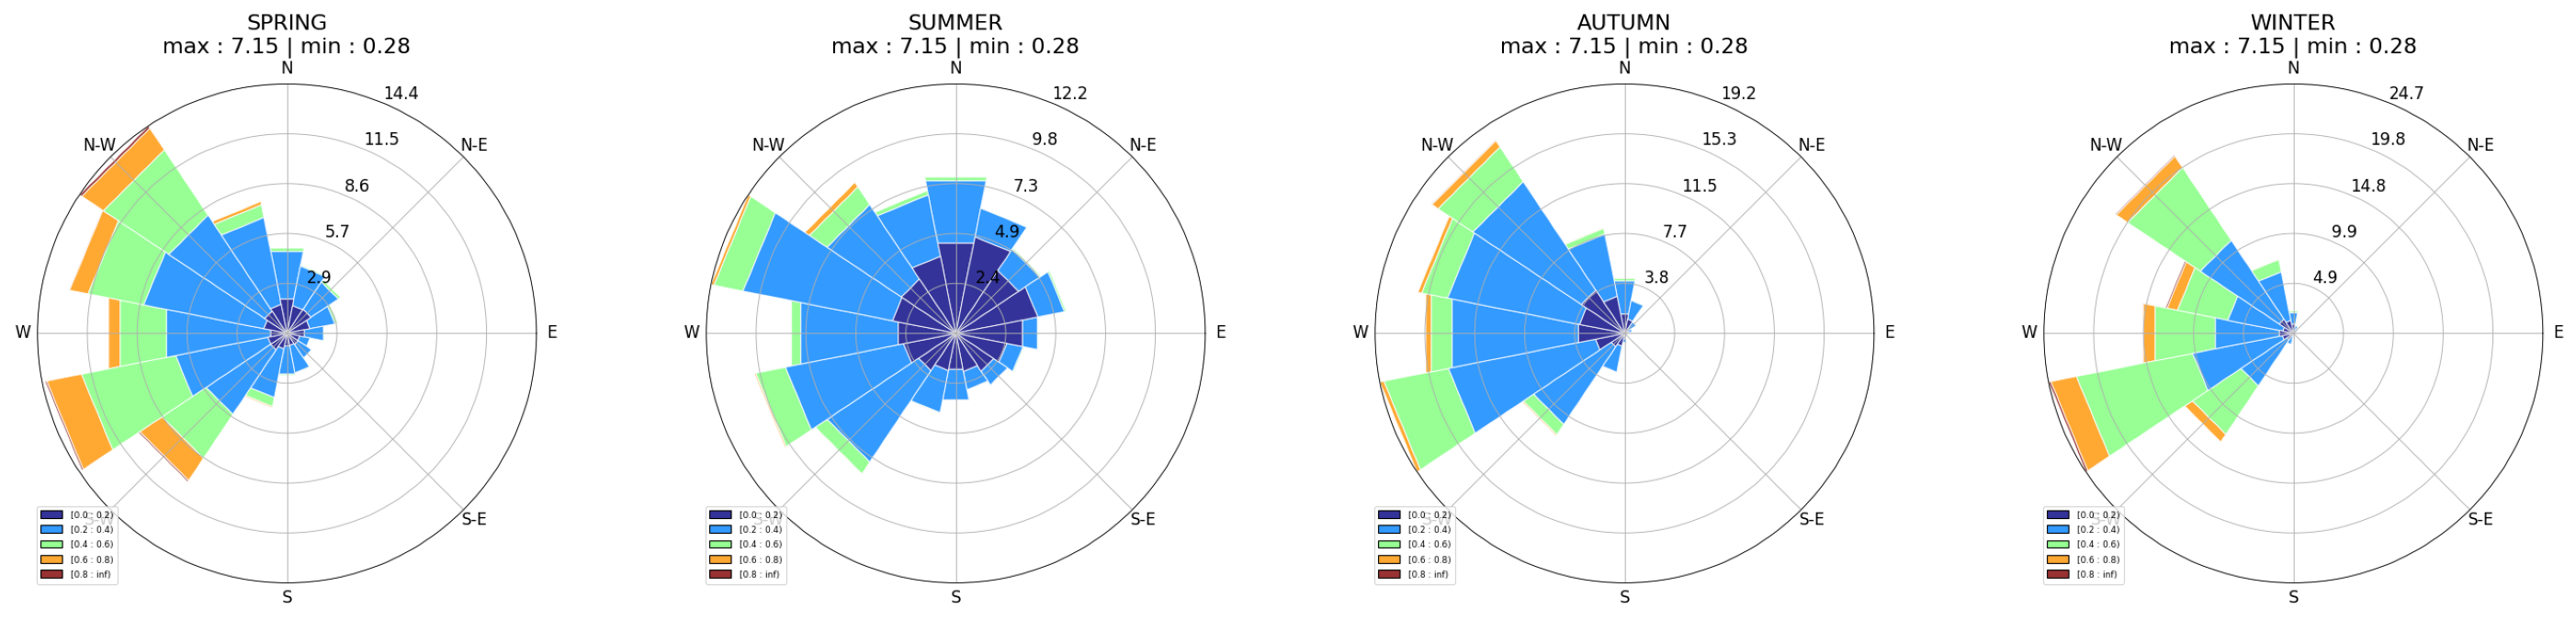

In [ ]:
dire = "/content/drive/My Drive/데이터 통합/OUTPUT/SEASON/"
season = ["SPRING_NORMED", "SUMMER_NORMED", "AUTUMN_NORMED","WINTER_NORMED"]
rows, cols = 1, 4
show_subplots(rows, cols, dire, season, [50, 30])

**봄: 북서(14.4%), 여름: 서북서(12.2%),가을: 서남서(19.2%), 겨울: 서남서(24.7%)**

###**9-2. 연도별 바람장미**

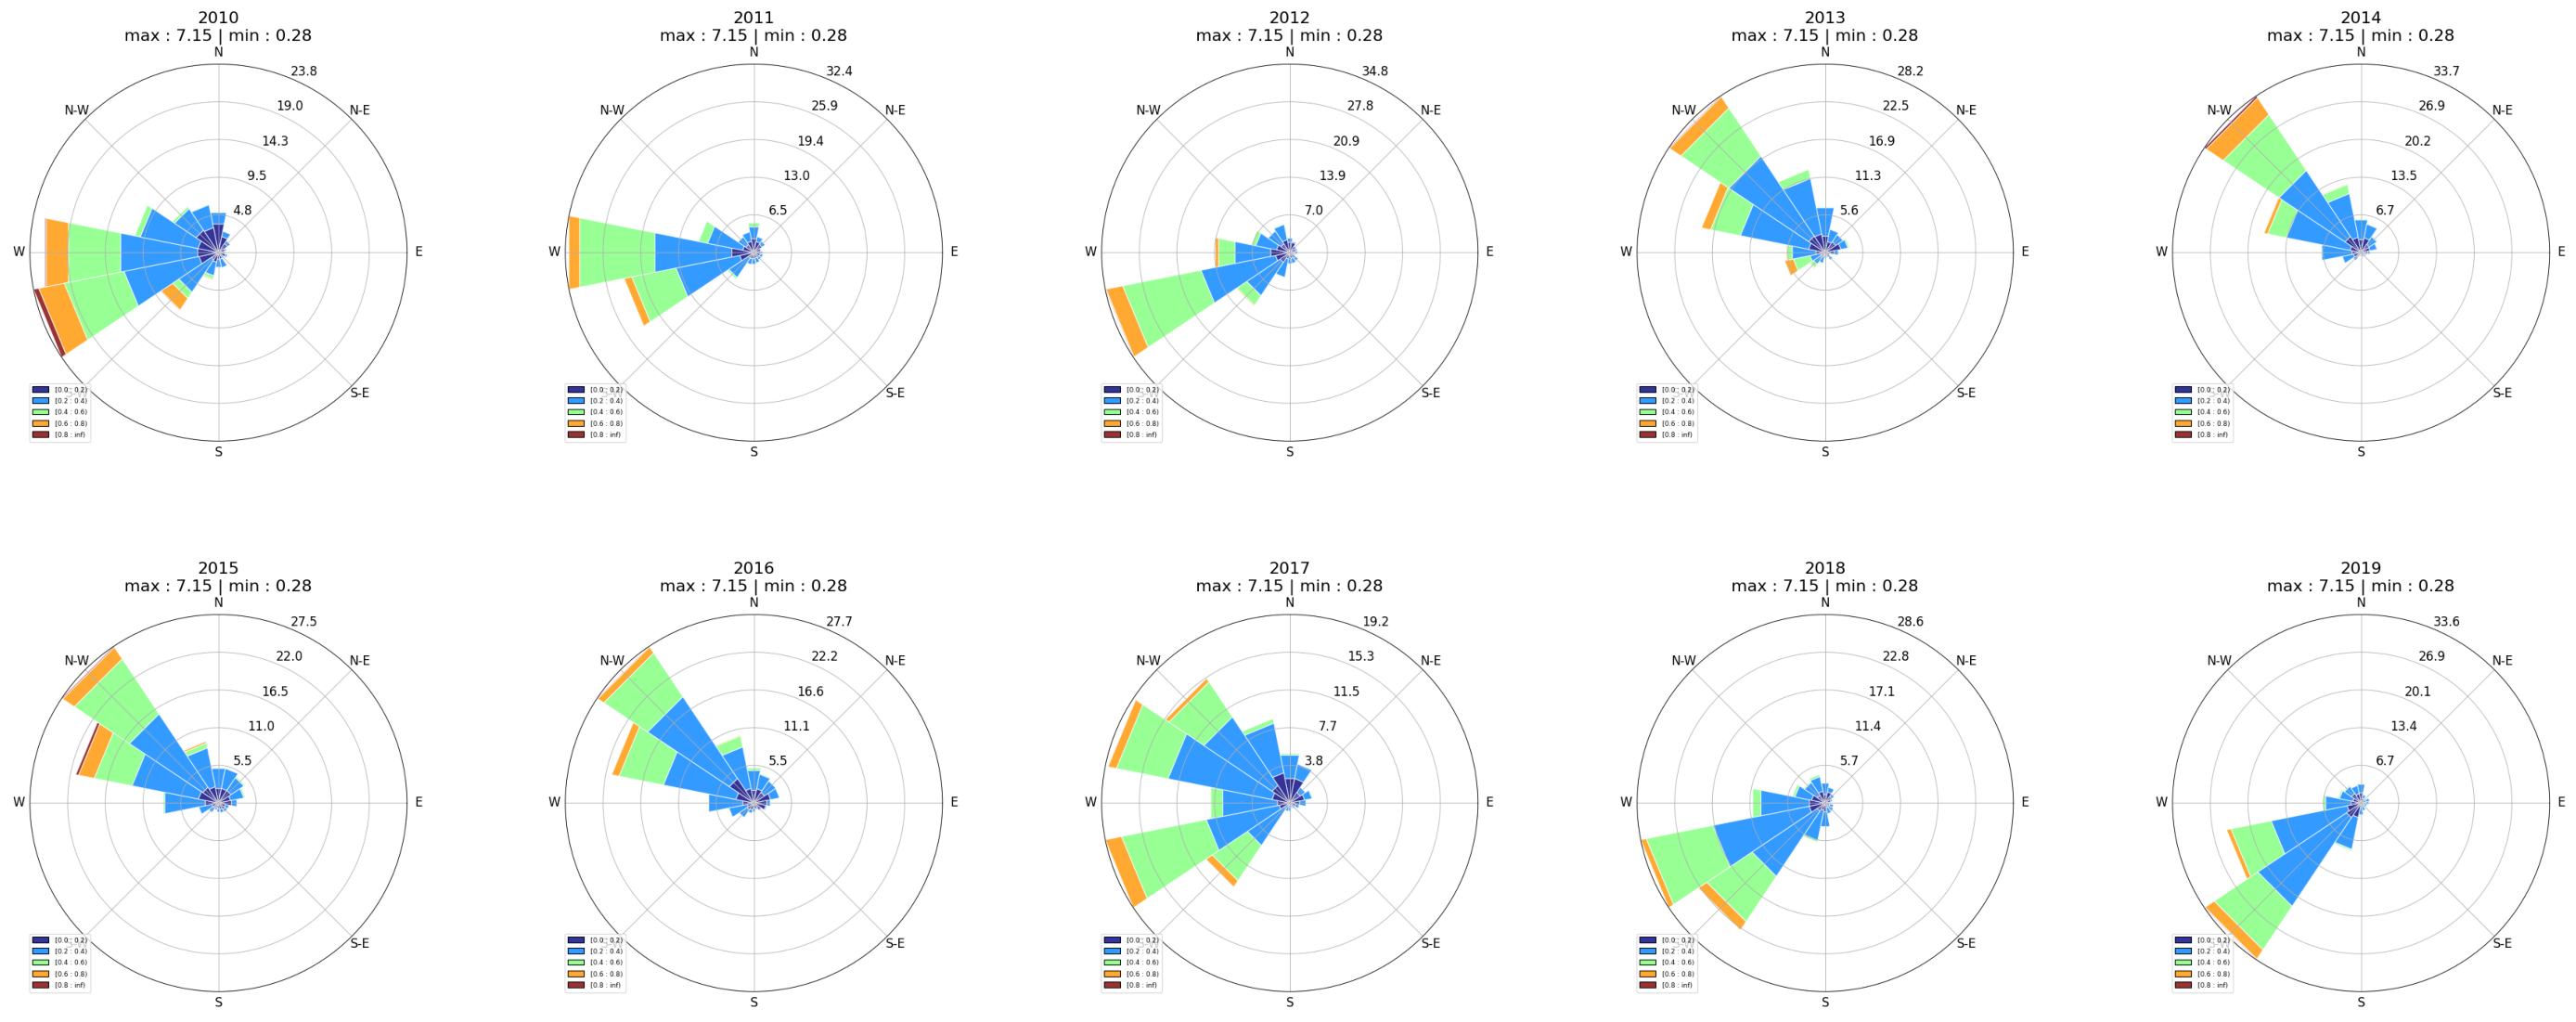

In [ ]:
dire = "/content/drive/My Drive/데이터 통합/OUTPUT/YEARLY/"
MONTH = [str(i) for i in range(2010, 2020)]
rows, cols = 2, 5
show_subplots(rows, cols, dire, MONTH, [50, 20])

###**9-3. 2015년 월별 바람장미**

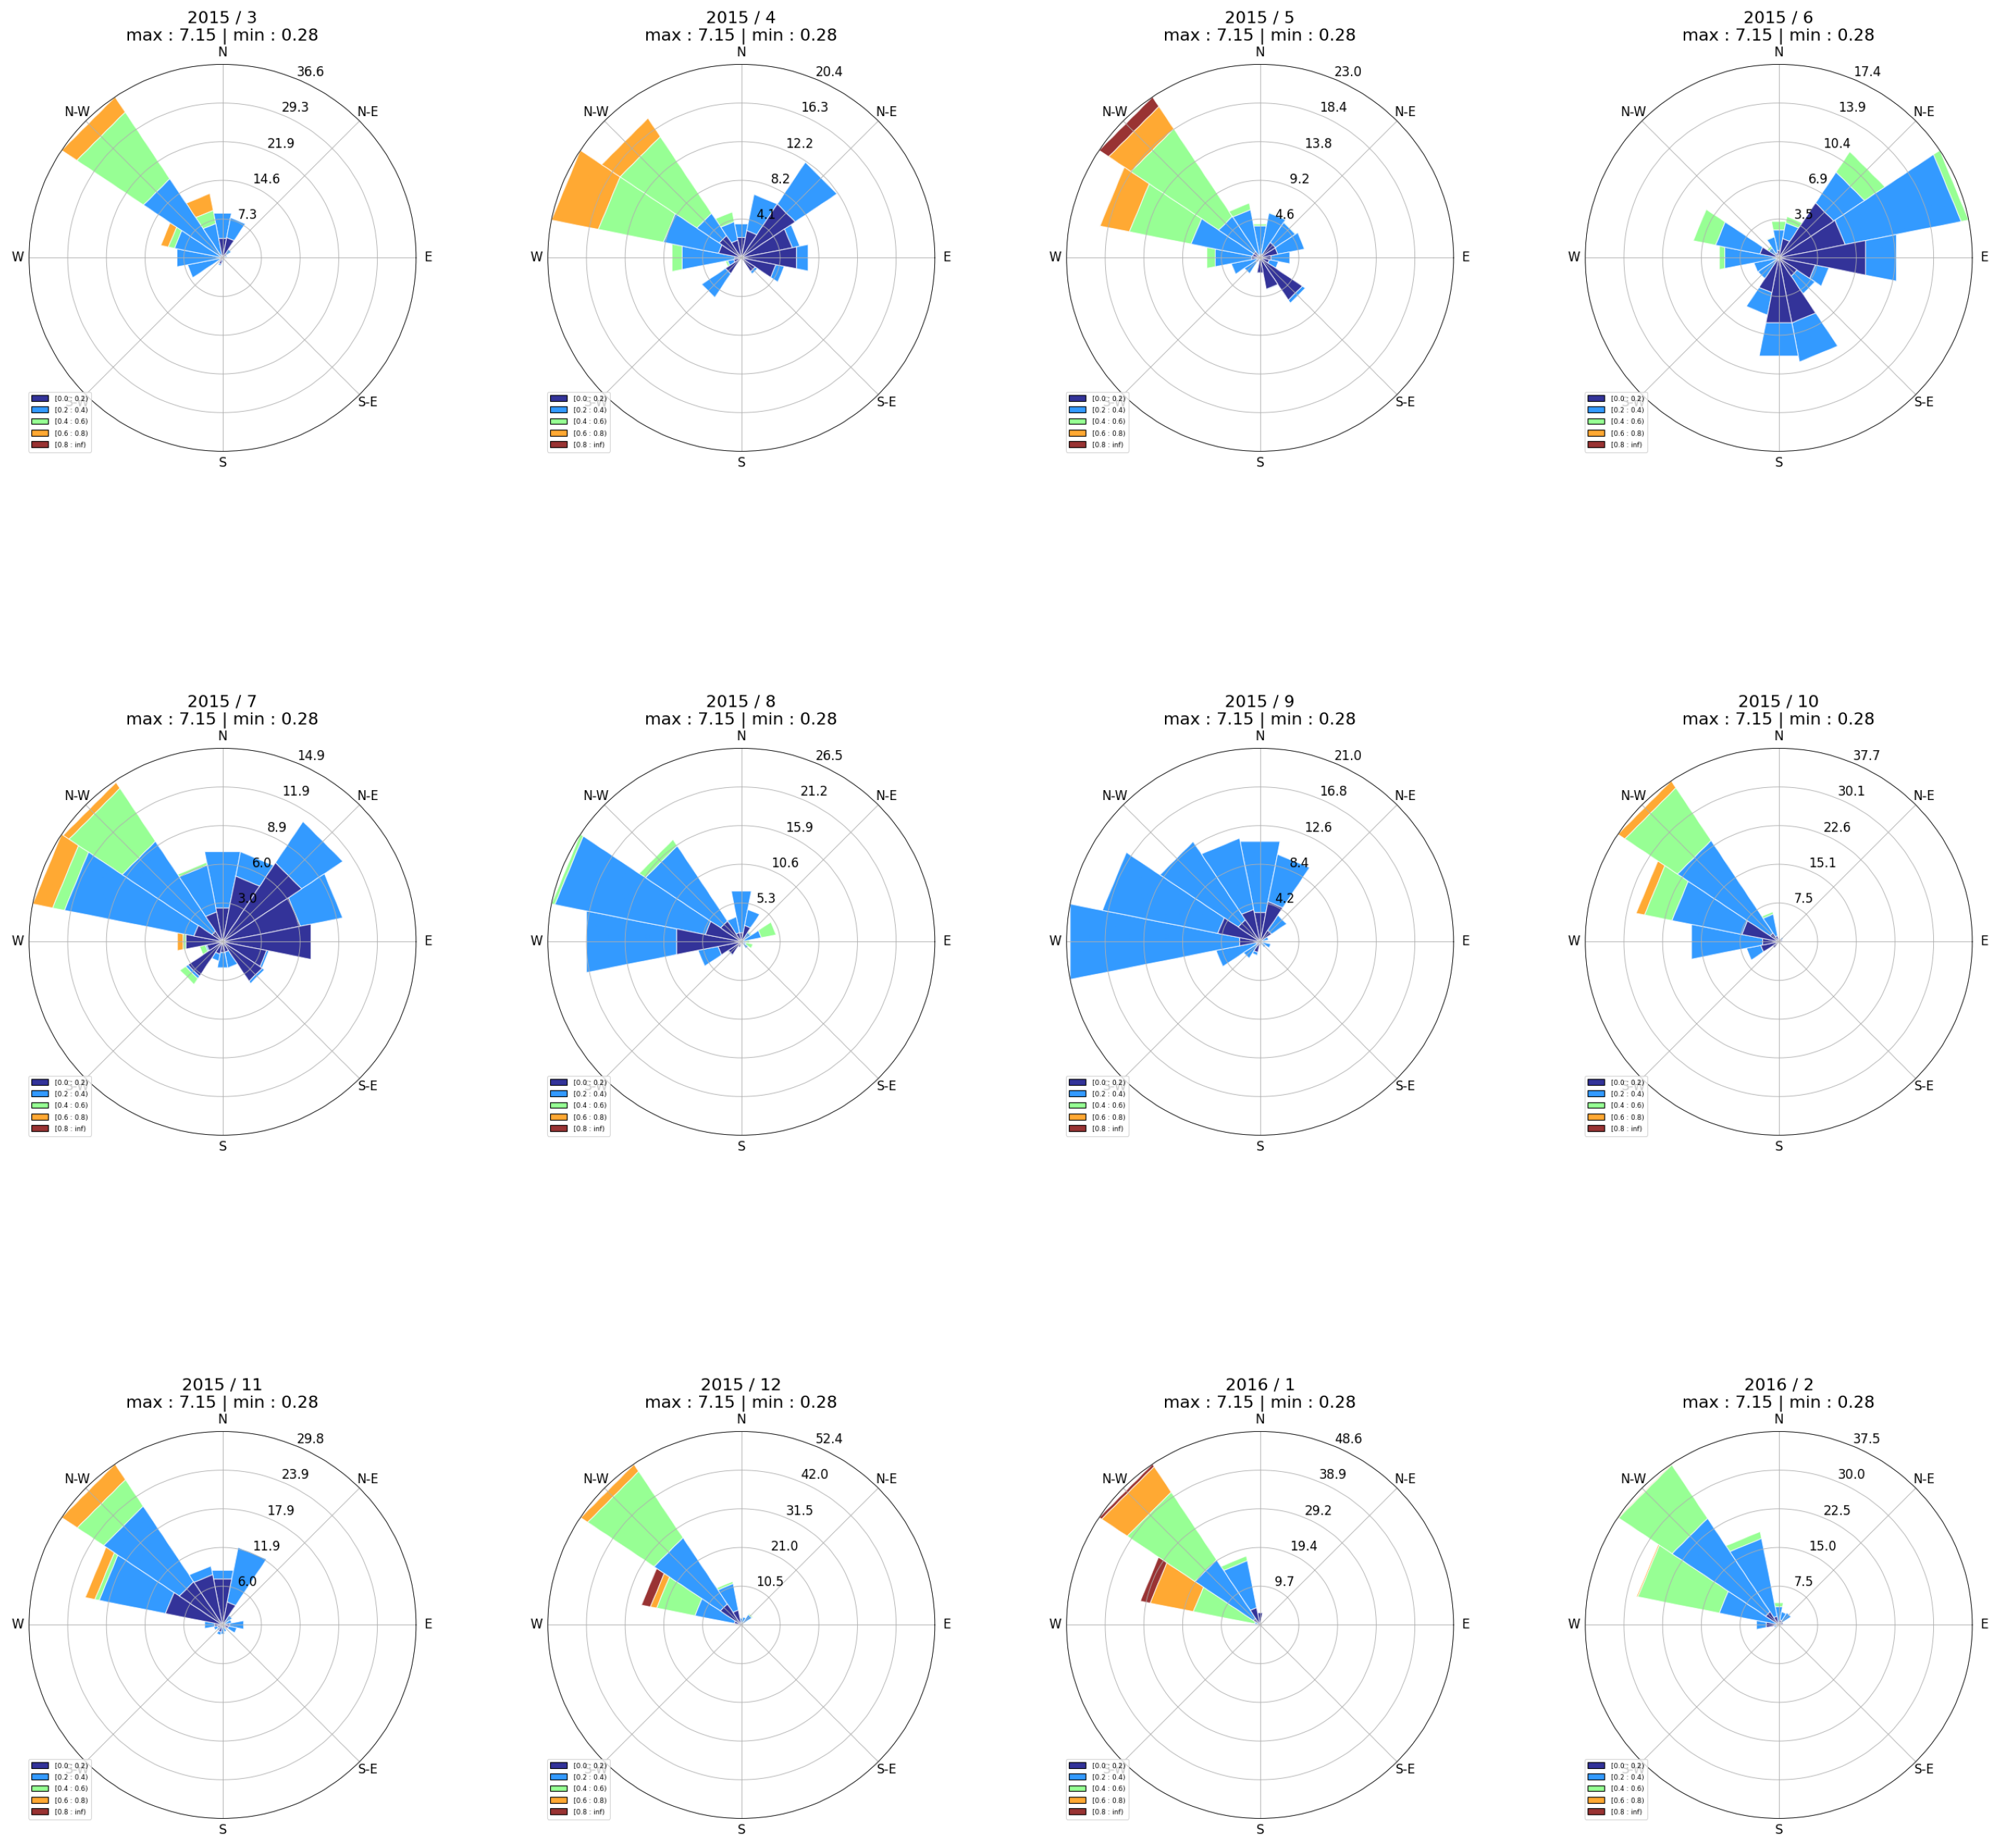

In [ ]:
dire = "/content/drive/My Drive/데이터 통합/OUTPUT/MONTHLY/2015/"
MONTH = [str(i + 1) for i in range(2, 12)] + ["1", "2"]
rows, cols = 3, 4
show_subplots(rows, cols, dire, MONTH, [50, 50])

###**9-4. 2019년 월별 바람장미**

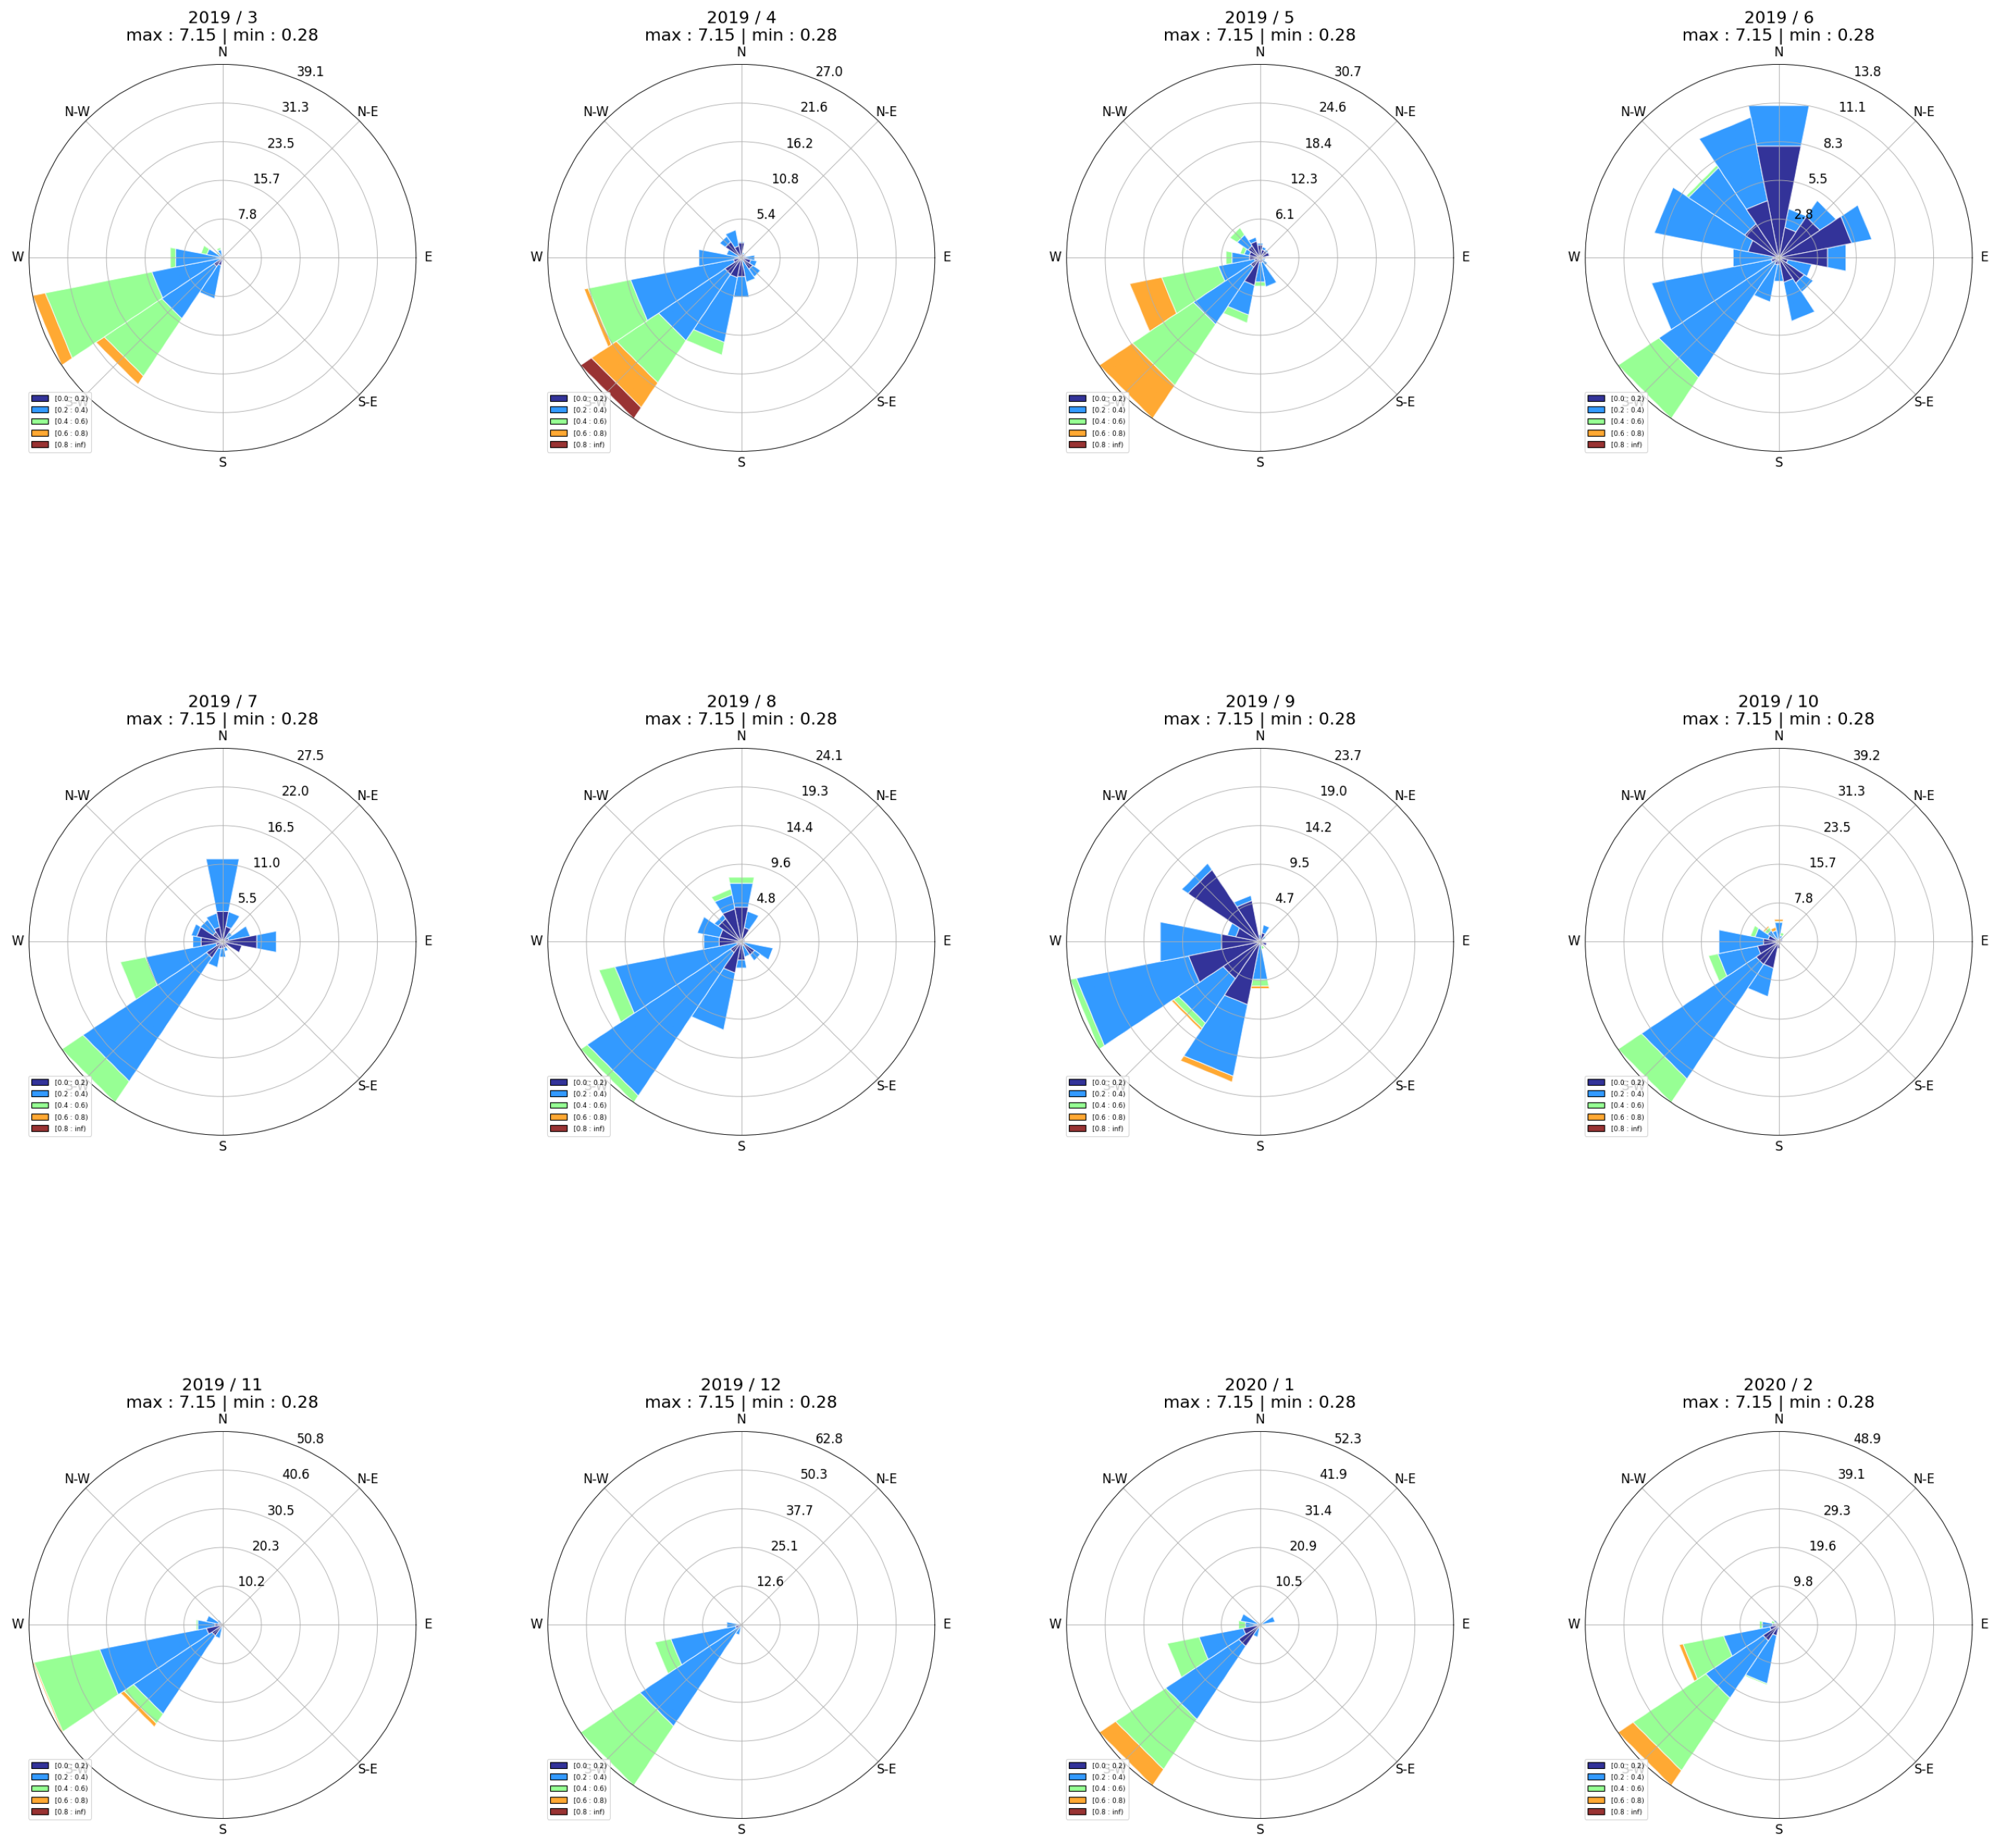

In [ ]:
dire = "/content/drive/My Drive/데이터 통합/OUTPUT/MONTHLY/2019/"
MONTH = [str(i + 1) for i in range(2, 12)] + ["1", "2"]
rows, cols = 3, 4
show_subplots(rows, cols, dire, MONTH, [50, 50])

In [ ]:
def slicing(start, end, data):
    START = np.where(data["시간"] == start)[0][0]
    STOP  = np.where(data["시간"] == end)[0][0]
    DF = data.iloc[START:STOP+1]
    return DF

In [ ]:
data = pd.read_csv("/content/drive/My Drive/데이터 통합/DATA/MERGED/moving_average.csv", encoding = "CP949")

# 2015년 강한 바람 중 겨울이 차지하는 비율
# 바람장미 제시하면서 2015년 바람 궁금해서 함

a = data[data['시간']=='2015-03-01 00:01:00']
b = data[data['시간']=='2016-03-01 00:00:00']

start = '2015-03-01 00:01:00'
end   = '2016-03-01 00:00:00'
data_2015 = slicing(start, end, data)
winter = '2015-12-01 00:01:00'
data_2015_winter = slicing(winter, end, data)

6.51*0.75                                                         #4.88/ 왜 0.75?
data_wwww=data_2015_winter[data_2015_winter['풍속(m/s)']>4.9]

data_dd=data_2015[data_2015['풍속(m/s)']>4.9]

6896/12043 *100  #57%  

57.26147969774973

---

### **9-5. 코사인 유사도(2015년과 2019년 비교)**

> #### **코사인 유사도(cosine similarity)?**
**벡터의 방향이 얼마나 비슷한지를 나타내는 방법. 두 벡터의 방향이 완전히 같을 경우 =1, 90°의 각을 이룰 경우 =0, 180°로 완전히 반대 방향인 경우 =-1의 값을 갖는다. 이 때 벡터의 크기는 값에 아무런 영향을 미치지 않는다.**

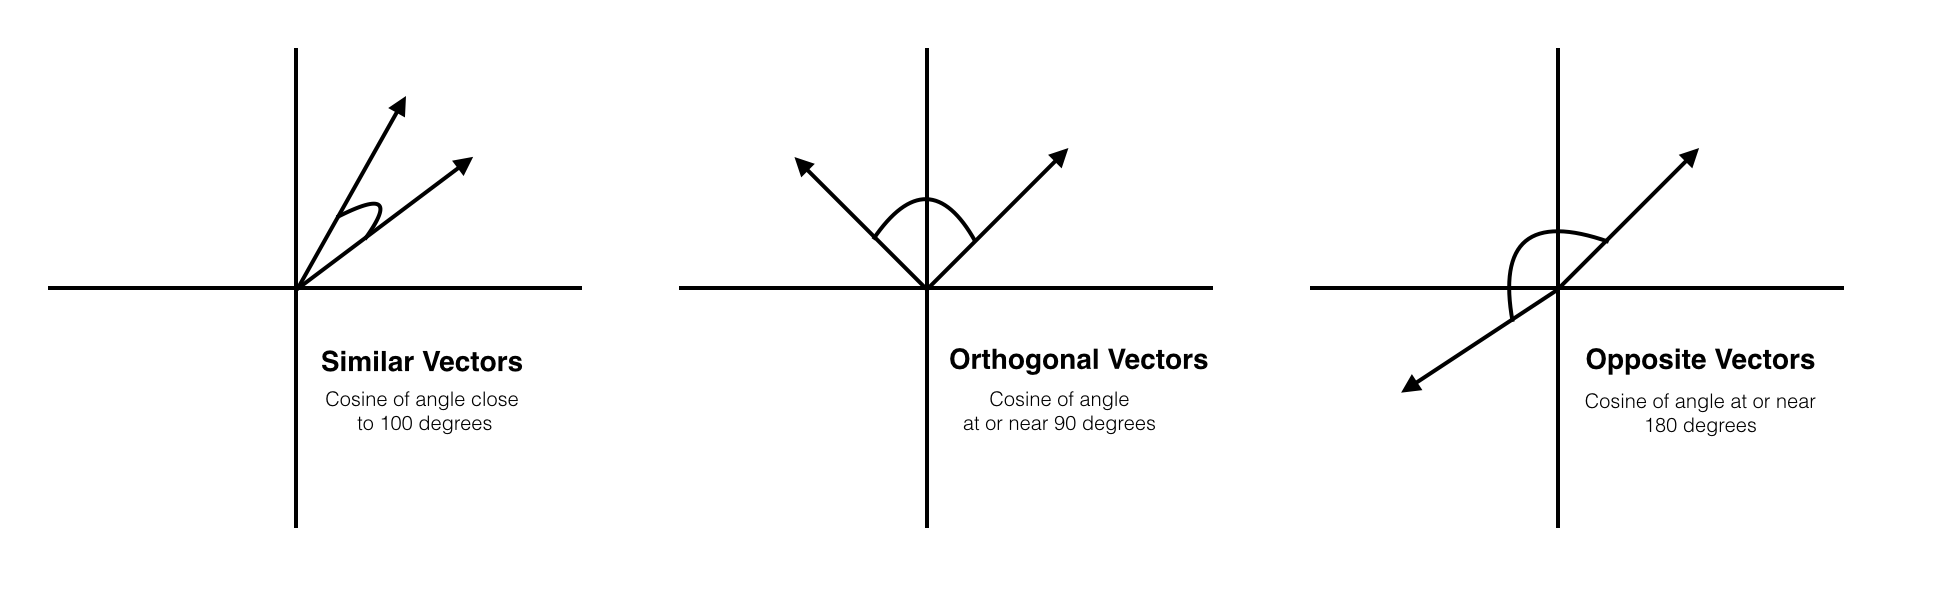

In [ ]:
c = pilimg.open('/content/drive/My Drive/데이터 통합/코사인유사도2.jpg')
c

In [ ]:
def cos_sim(A, B):
    rad = np.deg2rad(A - B)
    sim = np.cos(rad)
    return round(sim, 3)

In [ ]:
data_slice = pd.read_csv("/content/drive/My Drive/데이터 통합/DATA/MERGED/moving_average.csv", encoding = "CP949")

In [ ]:
data_sp_15 = slicing('2015-03-01 00:01:00','2015-06-01 00:00:00',data_slice)
data_su_15 = slicing('2015-06-01 00:01:00','2015-09-01 00:00:00',data_slice)
data_at_15 = slicing('2015-09-01 00:01:00','2015-12-01 00:00:00',data_slice)
data_wi_15 = slicing('2015-12-01 00:01:00','2016-03-01 00:00:00',data_slice)

In [ ]:
sp_15 = cos_sim(315,data_sp_15['풍향(deg)'])
su_15 = cos_sim(315,data_su_15['풍향(deg)'])
at_15 = cos_sim(315,data_at_15['풍향(deg)'])
wi_15 = cos_sim(315,data_wi_15['풍향(deg)'])

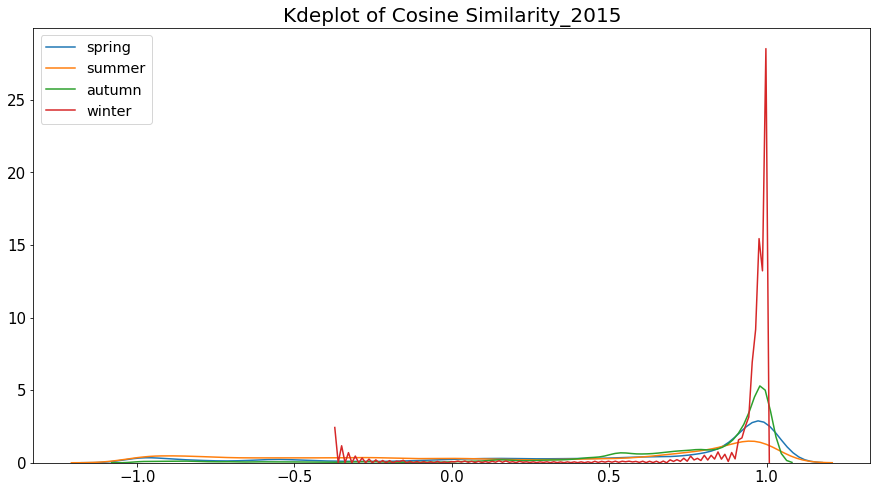

In [ ]:
#
plt.figure(figsize=(15,8))
sns.kdeplot(sp_15, label='spring')
sns.kdeplot(su_15, label='summer')
sns.kdeplot(at_15, label='autumn')
sns.kdeplot(wi_15, label='winter')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large')
plt.title('Kdeplot of Cosine Similarity_2015',fontsize=20);

In [ ]:
#겨울비교
data_2015 = pd.read_csv("/content/drive/My Drive/데이터 통합/DATA/1YR/15.csv", encoding = "CP949")
data_2019 = pd.read_csv("/content/drive/My Drive/데이터 통합/DATA/1YR/19.csv", encoding = "CP949")

In [ ]:
data_sp_19 = slicing('2019-03-01 00:01:00','2019-06-01 00:00:00',data_slice)
data_su_19 = slicing('2019-06-01 00:01:00','2019-09-01 00:00:00',data_slice)
data_at_19 = slicing('2019-09-01 00:01:00','2019-12-01 00:00:00',data_slice)
data_wi_19 = slicing('2019-12-01 00:01:00','2020-03-01 00:00:00',data_slice)

sp_19 = cos_sim(315,data_sp_19['풍향(deg)'])
su_19 = cos_sim(315,data_su_19['풍향(deg)'])
at_19 = cos_sim(315,data_at_19['풍향(deg)'])
wi_19 = cos_sim(315,data_wi_19['풍향(deg)'])

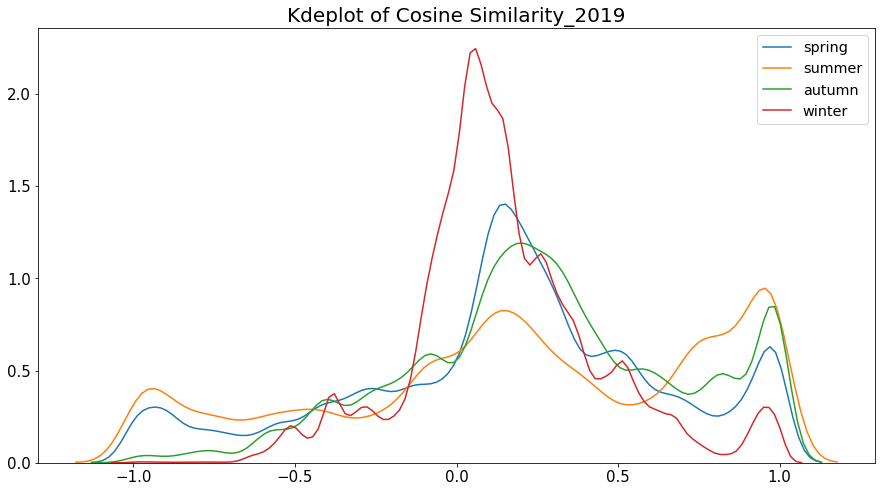

In [ ]:
plt.figure(figsize=(15,8))
sns.kdeplot(sp_19, label='spring')
sns.kdeplot(su_19, label='summer')
sns.kdeplot(at_19, label='autumn')
sns.kdeplot(wi_19, label='winter')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large')
plt.title('Kdeplot of Cosine Similarity_2019', fontsize=20);

In [ ]:
print(data_2015['기온(°C)'].mean())
print(data_2019['기온(°C)'].mean())

13.723272674414385
14.967131234794213


In [ ]:
print(data_sp_15['기온(°C)'].describe())
print(data_sp_19['기온(°C)'].describe())

count    132480.000000
mean         13.426213
std           6.930270
min          -1.031250
25%           7.238090
50%          13.851788
75%          19.003767
max          27.609687
Name: 기온(°C), dtype: float64
count    132480.000000
mean         14.141392
std           6.317747
min           3.921979
25%           8.725399
50%          13.387951
75%          19.447778
max          30.671389
Name: 기온(°C), dtype: float64


In [ ]:
print(data_su_15['기온(°C)'].describe())
print(data_su_19['기온(°C)'].describe())

count    132480.000000
mean         23.567535
std           3.679798
min          15.990486
25%          20.468785
50%          23.397465
75%          25.777951
max          32.483819
Name: 기온(°C), dtype: float64
count    132480.000000
mean         24.616446
std           3.760613
min          15.504514
25%          22.404045
50%          24.925104
75%          26.985799
max          31.935278
Name: 기온(°C), dtype: float64


In [ ]:
print(data_at_15['기온(°C)'].describe())
print(data_at_19['기온(°C)'].describe())

count    131040.000000
mean         15.373206
std           5.181019
min           0.565903
25%          11.738351
50%          16.565660
75%          19.644722
max          24.793368
Name: 기온(°C), dtype: float64
count    131040.000000
mean         16.102212
std           5.426768
min           3.156458
25%          12.683429
50%          16.394896
75%          20.151944
max          28.677986
Name: 기온(°C), dtype: float64


In [ ]:
print(data_wi_15['기온(°C)'].describe())
print(data_wi_19['기온(°C)'].describe())
#print(win_2015['풍속(m/s)'].mean())
#print(win_2019['풍속(m/s)'].mean())

count    131040.000000
mean          2.428337
std           3.796660
min         -10.102431
25%           0.028229
50%           2.567778
75%           5.165590
max          10.588125
Name: 기온(°C), dtype: float64
count    131040.000000
mean          4.910604
std           2.990697
min          -3.378854
25%           3.033542
50%           4.806528
75%           6.628976
max          12.705000
Name: 기온(°C), dtype: float64


#### **10. Q & A**